In [18]:
import logging
from pathlib import Path
from typing import Dict, List, Tuple

import joblib
import numpy as np
import pandas as pd

from sklearn.model_selection import GroupKFold
from sklearn.metrics import accuracy_score, f1_score, recall_score, roc_auc_score, confusion_matrix
from sklearn.preprocessing import PowerTransformer
from sklearn.feature_selection import VarianceThreshold
from sklearn.pipeline import Pipeline as SkPipeline

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

# -------------------------
# Config
# -------------------------
DATA_DIR = Path("datasets")
MODULE = "BBB"
PRESENTATIONS = ["2013B", "2013J"]

# Bạn có thể chỉnh danh sách cutoff để sinh nhiều sample hơn
CUTOFFS = [3, 5, 7, 10, 14, 21, 30, 45, 60, 90, 120, 150, 180]

WINDOW_DAYS = 14       # cửa sổ feature nhìn lại 14 ngày
HALF_WINDOW = 7        # chia 14 ngày thành 2 nửa: 0-7 và 8-14
HORIZON = 7            # dự đoán 7 ngày tương lai
VAR_THRESH = 0.0

MODEL_PATH = "short_term_inactive_next7days.pkl"

logging.basicConfig(level=logging.INFO, format="[%(asctime)s] %(levelname)s - %(message)s")



In [19]:
# === Cell 2: Load raw OULAD ===
def load_raw(data_dir: Path) -> Dict[str, pd.DataFrame]:
    return {
        "student_info": pd.read_csv(data_dir / "studentInfo.csv"),
        "student_reg": pd.read_csv(data_dir / "studentRegistration.csv"),
        "student_vle": pd.read_csv(data_dir / "studentVle.csv"),
    }


def prepare_students(raw: Dict[str, pd.DataFrame], module: str, presentations: List[str]):
    reg_mod = raw["student_reg"][
        (raw["student_reg"]["code_module"] == module)
        & (raw["student_reg"]["code_presentation"].isin(presentations))
    ].copy()

    reg_lookup = reg_mod[["id_student", "date_registration"]].drop_duplicates()

    students = raw["student_info"][
        (raw["student_info"]["code_module"] == module)
        & (raw["student_info"]["code_presentation"].isin(presentations))
        & (raw["student_info"]["id_student"].isin(reg_lookup["id_student"]))
    ].copy()

    vle_mod = raw["student_vle"][
        (raw["student_vle"]["code_module"] == module)
        & (raw["student_vle"]["code_presentation"].isin(presentations))
    ].merge(reg_lookup, on="id_student", how="inner")

    # ngày tương đối kể từ lúc đăng ký (học viên đăng ký muộn vẫn OK)
    vle_mod["days_since_reg"] = vle_mod["date"] - vle_mod["date_registration"]

    # Chỉ giữ những record có days_since_reg hợp lệ (>=0)
    vle_mod = vle_mod[vle_mod["days_since_reg"].notna()].copy()
    vle_mod = vle_mod[vle_mod["days_since_reg"] >= 0]

    logging.info("So hoc vien hop le: %d", students["id_student"].nunique())
    logging.info("So ban ghi VLE: %d", len(vle_mod))
    return students, vle_mod



In [20]:
# === Cell 3: Helpers ===
def compute_inactivity_streak(days_list: List[int], start_day: int, end_day: int) -> int:
    """
    Đếm số ngày liên tiếp KHÔNG hoạt động tính từ end_day lùi về start_day.
    """
    if not days_list:
        return end_day - start_day + 1
    active = set(days_list)
    streak, d = 0, end_day
    while d >= start_day and d not in active:
        streak += 1
        d -= 1
    return streak


def build_short_term_label(vle_mod: pd.DataFrame, cutoff: int, horizon: int = 7) -> pd.DataFrame:
    """
    Label ngắn hạn:
    y_short = 1 nếu KHÔNG có activity trong (cutoff+1 .. cutoff+horizon)
    """
    future = vle_mod[(vle_mod["days_since_reg"] > cutoff) & (vle_mod["days_since_reg"] <= cutoff + horizon)]

    has_future_activity = (
        future.groupby("id_student")["days_since_reg"].nunique().gt(0).astype(int).reset_index()
    ).rename(columns={"days_since_reg": "has_activity_next"})

    # y=1 nếu vắng (không hoạt động)
    has_future_activity["y_short"] = (has_future_activity["has_activity_next"] == 0).astype(int)
    return has_future_activity[["id_student", "y_short"]]


In [21]:
# === Cell 4: Build features (last 14 days) + label next 7 days ===
def build_features_short_term(
    students: pd.DataFrame,
    vle_mod: pd.DataFrame,
    cutoffs: List[int],
    window_days: int = WINDOW_DAYS,
    half_window: int = HALF_WINDOW,
    horizon: int = HORIZON,
) -> Tuple[pd.DataFrame, List[str]]:

    max_day_by_student = vle_mod.groupby("id_student")["days_since_reg"].max().reset_index()
    max_day_lookup = dict(zip(max_day_by_student["id_student"], max_day_by_student["days_since_reg"]))

    augmented = []
    for cutoff in cutoffs:
        # filter cutoff hợp lệ: phải còn đủ "tương lai 7 ngày"
        # nếu cutoff > (max_day - horizon) thì label tương lai sẽ thiếu => bỏ
        valid_students = [sid for sid in students["id_student"].unique()
                          if max_day_lookup.get(sid, -1) >= cutoff + horizon]
        if not valid_students:
            continue

        base = pd.DataFrame({"id_student": valid_students})
        base["cutoff"] = cutoff

        # Cửa sổ feature: [cutoff-13 .. cutoff]
        w_start = max(0, cutoff - (window_days - 1))
        w_end = cutoff

        vle_cum = vle_mod[(vle_mod["id_student"].isin(valid_students)) & (vle_mod["days_since_reg"] <= cutoff)].copy()
        vle_win = vle_cum[vle_cum["days_since_reg"] >= w_start].copy()

        # --- Cum features ---
        cum_agg = (
            vle_cum.groupby("id_student")
            .agg(
                total_clicks=("sum_click", "sum"),
                active_days_total=("days_since_reg", "nunique"),
                last_active=("days_since_reg", "max"),
            )
            .reset_index()
        )
        cum_agg["days_elapsed_since_reg"] = cutoff
        cum_agg["clicks_per_day_total"] = cum_agg["total_clicks"] / max(cutoff, 1)
        cum_agg["active_ratio_total"] = cum_agg["active_days_total"] / max(cutoff, 1)
        cum_agg["days_since_last_active"] = cutoff - cum_agg["last_active"]
        cum_agg["avg_clicks_per_active_day_total"] = (
            cum_agg["total_clicks"] / cum_agg["active_days_total"].replace(0, np.nan)
        ).fillna(0)

        # --- Window 14 days features ---
        win_agg = (
            vle_win.groupby("id_student")
            .agg(
                clicks_last_14_days=("sum_click", "sum"),
                active_days_14=("days_since_reg", "nunique")
            )
            .reset_index()
        )
        win_agg["clicks_per_day_14"] = win_agg["clicks_last_14_days"] / window_days
        win_agg["active_ratio_14"] = win_agg["active_days_14"] / window_days

        # Split 14 days into 0-7 & 8-14 (relative inside window)
        first_end = min(w_end, w_start + (half_window - 1))
        second_start = min(w_end, first_end + 1)

        clicks_0_7 = (
            vle_win[(vle_win["days_since_reg"] >= w_start) & (vle_win["days_since_reg"] <= first_end)]
            .groupby("id_student")["sum_click"].sum().reset_index(name="clicks_0_7")
        )
        clicks_8_14 = (
            vle_win[(vle_win["days_since_reg"] >= second_start) & (vle_win["days_since_reg"] <= w_end)]
            .groupby("id_student")["sum_click"].sum().reset_index(name="clicks_8_14")
        )

        clicks_last_7 = (
            vle_cum[vle_cum["days_since_reg"] > (cutoff - 7)]
            .groupby("id_student")["sum_click"].sum().reset_index(name="clicks_last_7_days")
        )

        # inactivity streak inside last 14 days
        days_list = (
            vle_win.groupby("id_student")["days_since_reg"]
            .apply(lambda x: sorted(x.unique()))
            .reset_index()
            .rename(columns={"days_since_reg": "active_days_list"})
        )
        days_list["inactivity_streak_14"] = days_list["active_days_list"].apply(
            lambda lst: compute_inactivity_streak(lst, w_start, w_end)
        )
        streak = days_list[["id_student", "inactivity_streak_14"]]

        # label next 7 days
        label_df = build_short_term_label(vle_mod[vle_mod["id_student"].isin(valid_students)], cutoff, horizon=horizon)

        merged = base.merge(label_df, on="id_student", how="left")
        # nếu không có record future (hiếm do mình đã filter), fallback coi như vắng
        merged["y_short"] = merged["y_short"].fillna(1).astype(int)

        merged = merged.merge(cum_agg, on="id_student", how="left")
        merged = merged.merge(win_agg, on="id_student", how="left")
        merged = merged.merge(clicks_0_7, on="id_student", how="left")
        merged = merged.merge(clicks_8_14, on="id_student", how="left")
        merged = merged.merge(clicks_last_7, on="id_student", how="left")
        merged = merged.merge(streak, on="id_student", how="left")

        # fill missing numeric with 0
        fill0 = [
            "total_clicks","active_days_total","last_active",
            "clicks_last_14_days","active_days_14",
            "clicks_0_7","clicks_8_14","clicks_last_7_days",
            "inactivity_streak_14",
            "days_elapsed_since_reg","clicks_per_day_total","active_ratio_total",
            "avg_clicks_per_active_day_total","days_since_last_active",
            "clicks_per_day_14","active_ratio_14"
        ]
        for col in fill0:
            if col in merged.columns:
                merged[col] = merged[col].fillna(0)

        merged["trend_click_14"] = merged["clicks_8_14"] - merged["clicks_0_7"]
        merged["ratio_click_14"] = (merged["clicks_8_14"] + 1) / (merged["clicks_0_7"] + 1)

        augmented.append(merged)

    final_df = pd.concat(augmented, ignore_index=True)

    feature_cols = [
        "days_elapsed_since_reg",
        "clicks_per_day_total",
        "active_ratio_total",
        "avg_clicks_per_active_day_total",
        "days_since_last_active",

        "clicks_last_14_days",
        "active_days_14",
        "clicks_per_day_14",
        "active_ratio_14",

        "clicks_last_7_days",
        "clicks_0_7",
        "clicks_8_14",
        "trend_click_14",
        "ratio_click_14",
        "inactivity_streak_14",
    ]
    return final_df, feature_cols


In [22]:
# === Cell 5: Pipelines + Models ===
def make_eval_pipe(model):
    return ImbPipeline([
        ("variance_threshold", VarianceThreshold(VAR_THRESH)),
        ("smote", SMOTE()),
        ("power_transformer", PowerTransformer()),
        ("classifier", model),
    ])

def make_prod_pipe(model):
    return SkPipeline([
        ("variance_threshold", VarianceThreshold(VAR_THRESH)),
        ("power_transformer", PowerTransformer()),
        ("classifier", model),
    ])

MODELS = {
    "LogisticRegression": LogisticRegression(
        penalty="l2",
        solver="lbfgs",
        max_iter=2000,
        class_weight="balanced",
        random_state=42
    ),
    "RandomForest": RandomForestClassifier(
        n_estimators=300,
        max_depth=12,
        min_samples_split=10,
        min_samples_leaf=5,
        random_state=42,
        n_jobs=-1,
        class_weight="balanced"
    ),
    "GradientBoosting": GradientBoostingClassifier(
        learning_rate=0.05,
        max_depth=3,
        min_samples_leaf=40,
        min_samples_split=20,
        n_estimators=150,
        random_state=42
    ),
    "MLP": MLPClassifier(
        hidden_layer_sizes=(128,),
        max_iter=1200,
        early_stopping=True,
        random_state=42
    )
}


In [23]:
# === Cell 6: Train/Eval GroupKFold + Save best ===
raw = load_raw(DATA_DIR)
students, vle_mod = prepare_students(raw, MODULE, PRESENTATIONS)

final_df, feature_cols = build_features_short_term(students, vle_mod, CUTOFFS, WINDOW_DAYS, HALF_WINDOW, HORIZON)

X = final_df[feature_cols].fillna(0)
y = final_df["y_short"].astype(int)          # 1 = vắng 7 ngày tới
groups = final_df["id_student"]

logging.info("Train samples: %d", len(final_df))
logging.info("Positive rate (vang): %.2f%%", 100 * y.mean())

gkf = GroupKFold(n_splits=5)
summary_rows = []

for name, model in MODELS.items():
    fold_rows = []
    for tr_idx, te_idx in gkf.split(X, y, groups):
        X_tr, X_te = X.iloc[tr_idx], X.iloc[te_idx]
        y_tr, y_te = y.iloc[tr_idx], y.iloc[te_idx]

        pipe = make_eval_pipe(model)
        pipe.fit(X_tr, y_tr)

        y_pred = pipe.predict(X_te)
        # một số model vẫn có predict_proba, nếu không thì fallback
        if hasattr(pipe, "predict_proba"):
            y_proba = pipe.predict_proba(X_te)[:, 1]
            auc = roc_auc_score(y_te, y_proba)
        else:
            y_proba = None
            auc = np.nan

        tn, fp, fn, tp = confusion_matrix(y_te, y_pred).ravel()
        fold_rows.append({
            "model": name,
            "accuracy": accuracy_score(y_te, y_pred),
            "f1": f1_score(y_te, y_pred),
            "recall_pos(vang)": recall_score(y_te, y_pred),               # bắt được ca vắng
            "specificity": tn / (tn + fp + 1e-9),                        # đúng ca không vắng
            "auc": auc,
        })

    df = pd.DataFrame(fold_rows)
    summary_rows.append({
        "model": name,
        "mean_accuracy": df["accuracy"].mean(),
        "mean_f1": df["f1"].mean(),
        "mean_recall_pos(vang)": df["recall_pos(vang)"].mean(),
        "mean_specificity": df["specificity"].mean(),
        "mean_auc": df["auc"].mean(),
    })

summary_df = pd.DataFrame(summary_rows).sort_values("mean_f1", ascending=False)
print("=== Hiệu năng trung bình (sort theo F1) ===")
display(summary_df)

best_model_name = summary_df.iloc[0]["model"]
best_model = MODELS[best_model_name]

prod_pipe = make_prod_pipe(best_model)
prod_pipe.fit(X, y)

joblib.dump({"pipeline": prod_pipe, "feature_cols": feature_cols}, MODEL_PATH)
print(f"✅ Saved model to: {MODEL_PATH} (best={best_model_name})")


[2025-12-28 09:06:57,882] INFO - So hoc vien hop le: 3960
[2025-12-28 09:06:57,883] INFO - So ban ghi VLE: 864034
[2025-12-28 09:06:59,292] INFO - Train samples: 40769
[2025-12-28 09:06:59,293] INFO - Positive rate (vang): 65.30%
/home/trong-viet/Desktop/lms/engtastic_ai/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
/home/trong-viet/Desktop/lms/engtastic_ai/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2',

=== Hiệu năng trung bình (sort theo F1) ===


,model,mean_accuracy,mean_f1,mean_recall_pos(vang),mean_specificity,mean_auc
1,RandomForest,0.858815,0.890508,0.879186,0.820410,0.880863
2,GradientBoosting,0.857147,0.888795,0.874186,0.824999,0.881561
3,MLP,0.855994,0.887609,0.870817,0.828228,0.881144
0,LogisticRegression,0.854547,0.886286,0.868013,0.829232,0.880580


✅ Saved model to: short_term_inactive_next7days.pkl (best=RandomForest)


In [24]:
# === Cell 7: Inference cho 1 học viên (nhập feature JSON) ===
bundle = joblib.load(MODEL_PATH)
loaded_pipe = bundle["pipeline"]
feature_cols = bundle["feature_cols"]

student_data = {
    "student_id": "60",
    "days_elapsed_since_reg": 31,
    "clicks_per_day_total": 0.16129032258064516,
    "active_ratio_total": 0.16129032258064516,
    "avg_clicks_per_active_day_total": 1,
    "days_since_last_active": 2,
    "clicks_last_14_days": 3,
    "active_days_14": 3,
    "clicks_per_day_14": 0.21428571428571427,
    "active_ratio_14": 0.21428571428571427,
    "clicks_last_7_days": 1,
    "clicks_0_7": 1,
    "clicks_8_14": 2,
    "trend_click_14": 1,
    "ratio_click_14": 1.5,
    "inactivity_streak_14": 6
  }


input_df = pd.DataFrame([student_data])[feature_cols].fillna(0)

proba_vang = loaded_pipe.predict_proba(input_df)[0, 1]
pred = loaded_pipe.predict(input_df)[0]  # 1 = vắng 7 ngày tới

print(f"--- Dự đoán NGẮN HẠN (vắng >7 ngày tới) cho student_id={student_data['student_id']} ---")
print(f"P(vắng 7 ngày tới): {proba_vang:.2%}")
print(f"Kết luận: {'⚠️ NGUY CƠ VẮNG' if pred==1 else '✅ CÓ KHẢ NĂNG VẪN HỌC'}")

# Bạn tự chọn ngưỡng cảnh báo
THRESHOLD = 0.6
if proba_vang >= THRESHOLD:
    print(f"Khuyến nghị: Gửi cảnh báo (threshold={THRESHOLD})")

--- Dự đoán NGẮN HẠN (vắng >7 ngày tới) cho student_id=60 ---
P(vắng 7 ngày tới): 24.73%
Kết luận: ✅ CÓ KHẢ NĂNG VẪN HỌC


In [25]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score, confusion_matrix
)

gkf = GroupKFold(n_splits=5)

metrics_rows = []  # mỗi model -> 1 dòng (mean theo fold)

for name, model in MODELS.items():
    fold_metrics = []

    for tr_idx, te_idx in gkf.split(X, y, groups):
        X_tr, X_te = X.iloc[tr_idx], X.iloc[te_idx]
        y_tr, y_te = y.iloc[tr_idx], y.iloc[te_idx]

        pipe = make_eval_pipe(model)
        pipe.fit(X_tr, y_tr)

        y_pred = pipe.predict(X_te)

        # proba cho class 1 (vang)
        if hasattr(pipe, "predict_proba"):
            y_proba = pipe.predict_proba(X_te)[:, 1]
            roc = roc_auc_score(y_te, y_proba)
            ap = average_precision_score(y_te, y_proba)
        else:
            y_proba = None
            roc = np.nan
            ap = np.nan

        fold_metrics.append({
            "accuracy": accuracy_score(y_te, y_pred),
            "precision_1": precision_score(y_te, y_pred, pos_label=1, zero_division=0),
            "recall_1": recall_score(y_te, y_pred, pos_label=1, zero_division=0),
            "f1_1": f1_score(y_te, y_pred, pos_label=1, zero_division=0),
            "roc_auc": roc,
            "avg_precision": ap,
            "support_1": int((y_te == 1).sum()),
        })

    df_fold = pd.DataFrame(fold_metrics)

    metrics_rows.append({
        "model": name,
        "accuracy": df_fold["accuracy"].mean(),
        "precision_1": df_fold["precision_1"].mean(),
        "recall_1": df_fold["recall_1"].mean(),
        "f1_1": df_fold["f1_1"].mean(),
        "roc_auc": df_fold["roc_auc"].mean(),
        "avg_precision": df_fold["avg_precision"].mean(),
        "support_1": int(df_fold["support_1"].mean()),  # mean support cho dễ nhìn
    })

metrics_df = pd.DataFrame(metrics_rows).set_index("model").sort_values("f1_1", ascending=False)
print("=== Metrics giống ảnh (mean theo 5-fold) ===")
display(metrics_df)


/home/trong-viet/Desktop/lms/engtastic_ai/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
/home/trong-viet/Desktop/lms/engtastic_ai/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
/home/trong-viet/Desktop/lms/engtastic_ai/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penal

=== Metrics giống ảnh (mean theo 5-fold) ===


,accuracy,precision_1,recall_1,f1_1,roc_auc,avg_precision,support_1
model,,,,,,,
RandomForest,0.858594,0.902327,0.878590,0.890286,0.880865,0.899335,5324
GradientBoosting,0.856852,0.903957,0.873633,0.888527,0.881685,0.899620,5324
MLP,0.856534,0.903943,0.873131,0.888248,0.881197,0.899412,5324
LogisticRegression,0.854498,0.905369,0.867934,0.886241,0.880554,0.899192,5324


/home/trong-viet/Desktop/lms/engtastic_ai/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(



=== LogisticRegression | TOP 15 Feature Importance ===
avg_clicks_per_active_day_total    1.319506
days_elapsed_since_reg             1.081265
active_days_14                     0.967415
active_ratio_total                 0.740130
inactivity_streak_14               0.738671
days_since_last_active             0.586784
clicks_per_day_total               0.535927
active_ratio_14                    0.428817
clicks_last_14_days                0.193992
clicks_per_day_14                  0.088779
clicks_last_7_days                 0.079842
clicks_8_14                        0.067488
clicks_0_7                         0.051557
ratio_click_14                     0.030822
trend_click_14                     0.025755


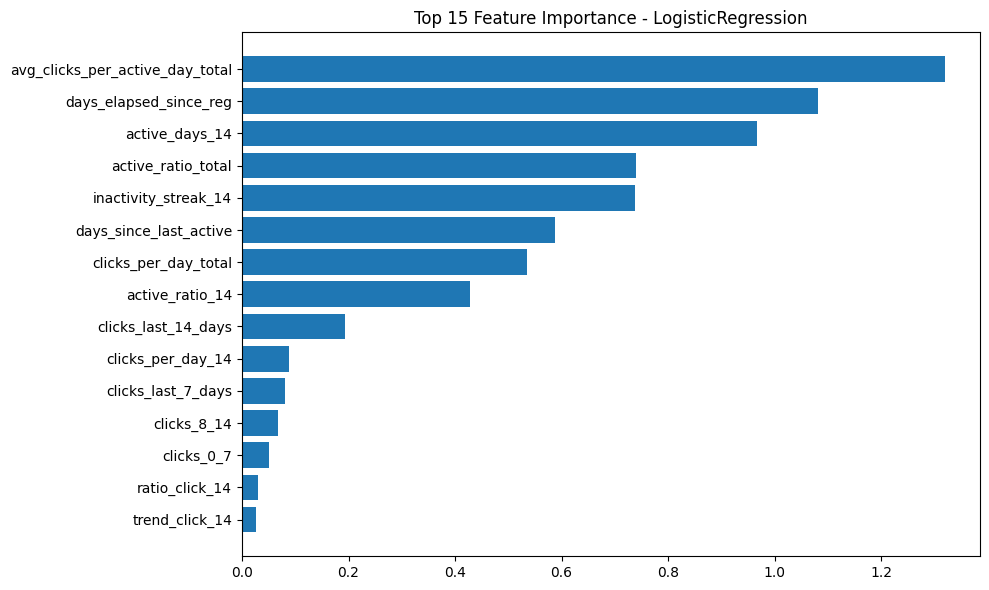


=== RandomForest | TOP 15 Feature Importance ===
clicks_per_day_total               0.195878
active_ratio_total                 0.160907
days_elapsed_since_reg             0.138729
avg_clicks_per_active_day_total    0.134048
active_ratio_14                    0.080340
clicks_per_day_14                  0.073703
clicks_last_14_days                0.070281
active_days_14                     0.038929
clicks_last_7_days                 0.038421
clicks_8_14                        0.020865
days_since_last_active             0.015832
clicks_0_7                         0.012322
ratio_click_14                     0.007572
trend_click_14                     0.006528
inactivity_streak_14               0.005645


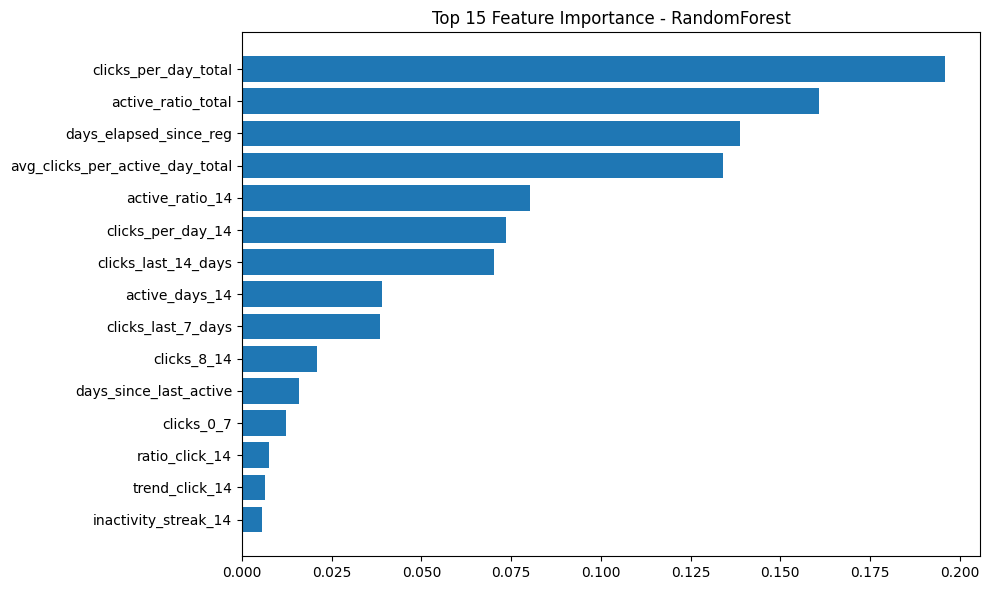


=== GradientBoosting | TOP 15 Feature Importance ===
clicks_per_day_14                  0.295256
active_ratio_14                    0.260804
active_days_14                     0.203712
clicks_last_7_days                 0.084480
clicks_last_14_days                0.074367
active_ratio_total                 0.046973
clicks_per_day_total               0.016050
days_elapsed_since_reg             0.008928
days_since_last_active             0.004260
inactivity_streak_14               0.001491
avg_clicks_per_active_day_total    0.001273
ratio_click_14                     0.000892
trend_click_14                     0.000627
clicks_8_14                        0.000560
clicks_0_7                         0.000326


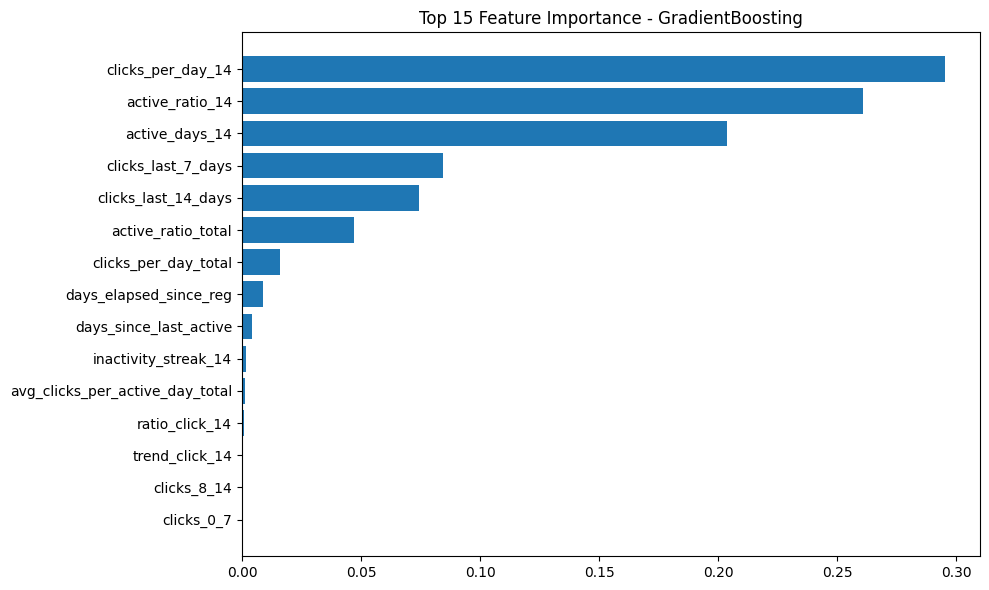


=== MLP | TOP 15 Feature Importance ===
active_ratio_total                 0.001680
active_ratio_14                    0.001653
clicks_last_7_days                 0.000911
trend_click_14                     0.000649
ratio_click_14                     0.000627
days_elapsed_since_reg             0.000510
clicks_per_day_14                  0.000502
clicks_8_14                       -0.000209
clicks_per_day_total              -0.000237
clicks_0_7                        -0.000358
active_days_14                    -0.000575
clicks_last_14_days               -0.000612
inactivity_streak_14              -0.000656
avg_clicks_per_active_day_total   -0.000752
days_since_last_active            -0.002369


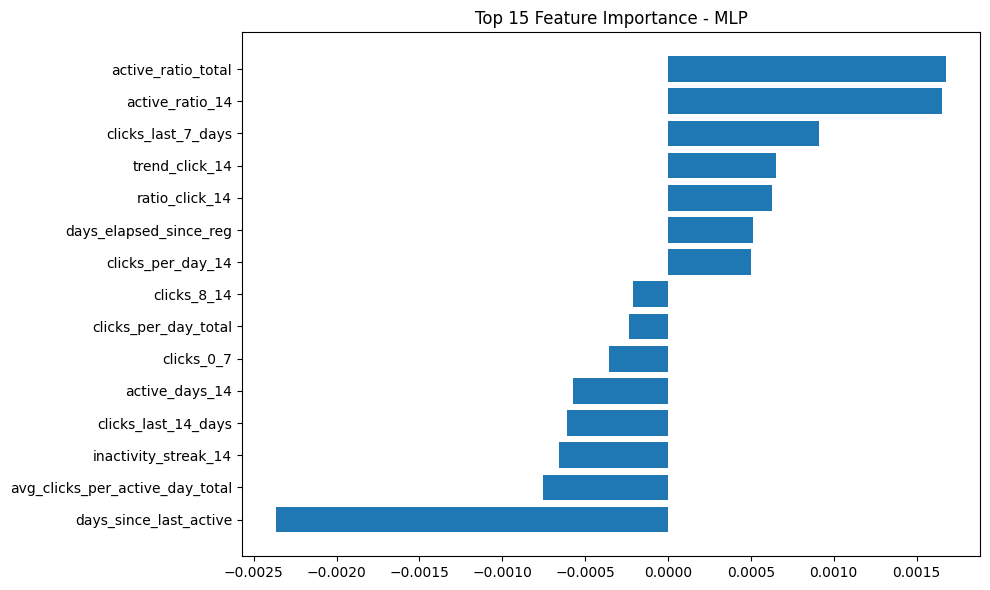


=== Combined importance table (union top-10 mỗi model) ===


,LogisticRegression,RandomForest,GradientBoosting,MLP
avg_clicks_per_active_day_total,1.319506,0.134048,0.001273,-0.000752
days_elapsed_since_reg,1.081265,0.138729,0.008928,0.000510
active_days_14,0.967415,0.038929,0.203712,-0.000575
active_ratio_total,0.740130,0.160907,0.046973,0.001680
inactivity_streak_14,0.738671,0.005645,0.001491,-0.000656
days_since_last_active,0.586784,0.015832,0.004260,-0.002369
clicks_per_day_total,0.535927,0.195878,0.016050,-0.000237
active_ratio_14,0.428817,0.080340,0.260804,0.001653
clicks_last_14_days,0.193992,0.070281,0.074367,-0.000612
clicks_per_day_14,0.088779,0.073703,0.295256,0.000502


In [26]:
from sklearn.inspection import permutation_importance

def get_classifier_from_pipe(pipe):
    # hỗ trợ cả pipeline của sklearn và imblearn
    if hasattr(pipe, "named_steps"):
        # bạn đặt step tên "classifier" trong make_*_pipe
        return pipe.named_steps.get("classifier")
    return pipe

# Fit FULL cho từng model theo pipeline production (không SMOTE)
fitted_prod_pipes = {}

for name, model in MODELS.items():
    p = make_prod_pipe(model)
    p.fit(X, y)
    fitted_prod_pipes[name] = p

# ---- 1) Logistic importance (abs coef) ----
def logistic_importance(pipe):
    clf = get_classifier_from_pipe(pipe)
    coefs = np.abs(clf.coef_).ravel()
    return pd.Series(coefs, index=feature_cols).sort_values(ascending=False)

# ---- 2) Tree-based importance ----
def tree_importance(pipe):
    clf = get_classifier_from_pipe(pipe)
    return pd.Series(clf.feature_importances_, index=feature_cols).sort_values(ascending=False)

# ---- 3) Permutation importance (dùng cho MLP hoặc bất cứ model nào) ----
def perm_importance(pipe, X_ref, y_ref, n_repeats=10):
    r = permutation_importance(pipe, X_ref, y_ref, n_repeats=n_repeats, random_state=42, scoring="f1")
    return pd.Series(r.importances_mean, index=feature_cols).sort_values(ascending=False)

# Chọn một sample X_ref để permutation (đỡ tốn thời gian)
# Nếu máy bạn khỏe có thể dùng toàn bộ X, y
X_ref = X.sample(min(5000, len(X)), random_state=42)
y_ref = y.loc[X_ref.index]

all_imps = {}

for name, pipe in fitted_prod_pipes.items():
    clf = get_classifier_from_pipe(pipe)

    if isinstance(clf, LogisticRegression):
        imp = logistic_importance(pipe)
    elif hasattr(clf, "feature_importances_"):
        imp = tree_importance(pipe)
    else:
        imp = perm_importance(pipe, X_ref, y_ref, n_repeats=8)

    all_imps[name] = imp

    print(f"\n=== {name} | TOP 15 Feature Importance ===")
    print(imp.head(15).to_string())

    # plot top 15
    topk = imp.head(15)[::-1]
    plt.figure(figsize=(10,6))
    plt.barh(topk.index, topk.values)
    plt.title(f"Top 15 Feature Importance - {name}")
    plt.tight_layout()
    plt.show()

# (tuỳ chọn) Bảng tổng hợp union top features
top_union = set()
for name, imp in all_imps.items():
    top_union.update(imp.head(10).index.tolist())

combined = pd.DataFrame({name: all_imps[name] for name in all_imps}).fillna(0)
combined = combined.loc[list(top_union)].sort_values(by=combined.columns.tolist(), ascending=False)
print("\n=== Combined importance table (union top-10 mỗi model) ===")
display(combined)
